In [1]:
import pandas as pd
import numpy as np
import pickle
import operator
import copy

from scipy.stats import boxcox

from dateutil.parser import parse
from datetime import datetime

import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [42]:
with open('books_cleaned.pkl', 'rb') as picklefile:
    books = pickle.load(picklefile)

In [44]:
books.b_avg_rating.describe()

count    742.000000
mean       3.943369
std        0.249572
min        3.000000
25%        3.790000
50%        3.950000
75%        4.100000
max        4.760000
Name: b_avg_rating, dtype: float64

In [3]:
books.drop(['a_id', 'b_id', 'b_ratings_count', 'pub_yr'], axis=1, inplace=True)

Create dummy variables

In [4]:
dummy_columns = ['hometown', 'gender', 'decade', 'b_wks_on_list', 'a_wks_on_list', 'a_books_on_list']
dummies = books[dummy_columns]
books.drop(['hometown', 'gender', 'decade'], axis=1, inplace=True)

In [5]:
#hometown in NY
dummies.loc[dummies['hometown'].str.contains('New York'), 'a_ny_hometown'] = 1
dummies['a_ny_hometown'].fillna(0, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

In [6]:
gender_dummies = pd.get_dummies(dummies['gender'], prefix='a', drop_first=True)
dummies = dummies.merge(gender_dummies, left_index=True, right_index=True)

In [7]:
decade_dummies = pd.get_dummies(dummies['decade'], prefix='b', drop_first=True)
dummies = dummies.merge(decade_dummies, left_index=True, right_index=True)

In [8]:
dummies.loc[dummies['b_wks_on_list'] > 1, 'b_repeat'] = 1
dummies['b_repeat'].fillna(0, inplace=True)

In [9]:
dummies.loc[dummies['a_wks_on_list'] > 1, 'a_repeat'] = 1
dummies['a_repeat'].fillna(0, inplace=True)

In [10]:
dummies.drop(dummy_columns, axis=1, inplace=True)

Keep only numerical features

In [11]:
num_columns = []
for column in books.columns:
    if np.dtype(books[column]) == 'float64' or np.dtype(books[column]) == 'int64':
        num_columns.append(column)
books = books[num_columns]

Use boxcox on skewed features

In [12]:
bc = pd.DataFrame()

In [13]:
bc_columns = ['b_count', 'b_rating_5_count', 'b_rating_4_count', 'b_rating_3_count', \
              'a_works_count', 'a_ratings_count', 'a_text_reviews_count', 'b_wks_on_list', \
              'a_wks_on_list', 'a_books_on_list']

In [14]:
bc['b_count_bx'] = boxcox(books['b_count'])[0]
bc['b_rating_5_count_bx'] = boxcox(books['b_rating_5_count'])[0]
bc['b_rating_4_count_bx'] = boxcox(books['b_rating_4_count'])[0]
bc['b_rating_3_count_bx'] = boxcox(books['b_rating_3_count'])[0]
bc['a_works_count_bx'] = boxcox(books['a_works_count'])[0]
bc['a_ratings_count_bx'] = boxcox(books['a_ratings_count'])[0]
bc['a_text_reviews_count_bx'] = boxcox(books['a_text_reviews_count'])[0]
bc['b_wks_on_list_bx'] = boxcox(books['b_wks_on_list'])[0]
bc['a_wks_on_list_bx'] = boxcox(books['a_wks_on_list'])[0]
bc['a_books_on_list_bx'] = boxcox(books['a_books_on_list'])[0]

In [15]:
#Error: 'ValueError: Data must be positive.'
#bc['b_txt_rev_count_bx'] = boxcox(books['b_txt_rev_count'])[0]
#bc['b_rating_2_count_bx'] = boxcox(books['b_rating_2_count'])[0]
#bc['b_rating_1_count_bx'] = boxcox(books['b_rating_1_count'])[0]
#bc['a_fans_count_bx'] = boxcox(books['a_fans_count'])[0]

Add boxcox features back to books df

In [16]:
books = books.join(bc)

Standardize numerical features (not dummies)

In [17]:
columns = books.columns
books = pd.DataFrame(preprocessing.scale(books))
books.columns = columns

Add categorical features back to books df

In [18]:
books = books.join(dummies)

In [19]:
books.drop(bc_columns, axis=1, inplace=True)

In [20]:
books.to_pickle('books_for_modeling.pkl')

In [21]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 28 columns):
b_avg_rating               742 non-null float64
b_txt_rev_count            742 non-null float64
b_rating_2_count           742 non-null float64
b_rating_1_count           742 non-null float64
a_fans_count               742 non-null float64
a_avg_rating               742 non-null float64
b_count_bx                 742 non-null float64
b_rating_5_count_bx        742 non-null float64
b_rating_4_count_bx        742 non-null float64
b_rating_3_count_bx        742 non-null float64
a_works_count_bx           742 non-null float64
a_ratings_count_bx         742 non-null float64
a_text_reviews_count_bx    742 non-null float64
b_wks_on_list_bx           742 non-null float64
a_wks_on_list_bx           742 non-null float64
a_books_on_list_bx         742 non-null float64
a_ny_hometown              742 non-null float64
a_male                     742 non-null float64
a_not reported             742 

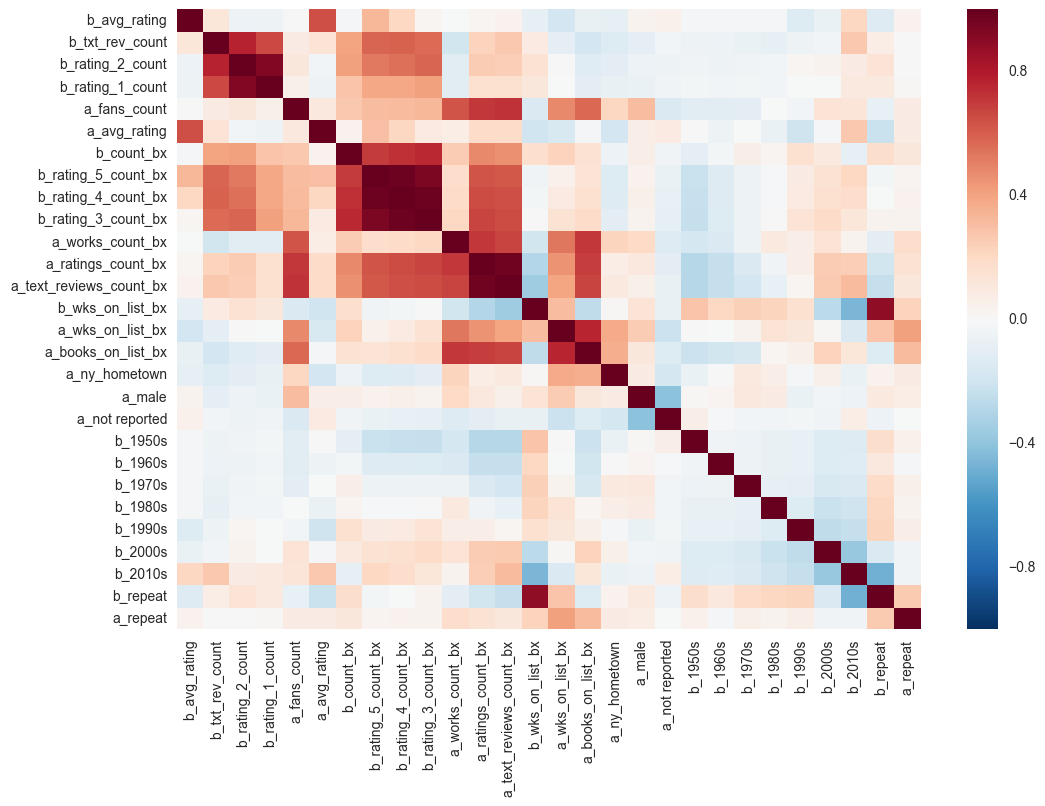

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(books.corr(), ax=ax);

### _Model 1: All features_

In [24]:
model1 = books
y = model1.pop('b_avg_rating')

In [25]:
lsm = sm.OLS(y,model1)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           b_avg_rating   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     268.3
Date:                Fri, 03 Feb 2017   Prob (F-statistic):               0.00
Time:                        02:13:58   Log-Likelihood:                -158.85
No. Observations:                 742   AIC:                             371.7
Df Residuals:                     715   BIC:                             496.2
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
b_txt_rev_count            -0.1380      0.024     -5.868      0.000        -0.184    -0.092
b_rating_2_count            0.2784      0.043      6.421      0.000         0.193     0.364
b_rating_1_count           -0.1604      0.034     -4.659      0.000        -0.228    -0.093
a_fans_count                0.0262      0.021      1.245      0.214        -0.015     0.067
a_avg_rating                0.0932      0.016      5.694      0.000         0.061     0.125
b_count_bx                 -0.0693      0.020     -3.545      0.000        -0.108    -0.031
b_rating_5_count_bx         1.4307      0.090     15.873      0.000         1.254     1.608
b_rating_4_count_bx         2.4100      0.152     15.828      0.000         2.111     2.709
b_rating_3_count_bx        -3.6233      0.094    -38.577      0.000        -3.808    -3.439
a_works_count_bx            0.0288      0.022      1.316      0.189        -0.014     0.072
a_ratings_count_bx          0.0393      0.071      0.557      0.578        -0.099     0.178
a_text_reviews_count_bx    -0.1088      0.071     -1.529      0.127        -0.249     0.031
b_wks_on_list_bx           -0.0057      0.037     -0.154      0.877        -0.079     0.067
a_wks_on_list_bx           -0.0535      0.036     -1.469      0.142        -0.125     0.018
a_books_on_list_bx          0.1120      0.040      2.832      0.005         0.034     0.190
a_ny_hometown               0.0387      0.033      1.168      0.243        -0.026     0.104
a_male                     -0.1313      0.030     -4.316      0.000        -0.191    -0.072
a_not reported             -0.0178      0.041     -0.435      0.664        -0.098     0.062
b_1950s                    -0.1981      0.068     -2.922      0.004        -0.331    -0.065
b_1960s                    -0.1622      0.069     -2.365      0.018        -0.297    -0.028
b_1970s                    -0.1938      0.066     -2.952      0.003        -0.323    -0.065
b_1980s                    -0.1323      0.058     -2.295      0.022        -0.245    -0.019
b_1990s                    -0.1537      0.060     -2.549      0.011        -0.272    -0.035
b_2000s                    -0.1408      0.059     -2.398      0.017        -0.256    -0.026
b_2010s                    -0.2531      0.062     -4.111      0.000        -0.374    -0.132
b_repeat                    0.1835      0.055      3.331      0.001         0.075     0.292
a_repeat                    0.1326      0.050      2.645      0.008         0.034     0.231
==============================================================================
Omnibus:                      215.606   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1687.906
Skew:                          -1.081   Prob(JB):                         0.00
Kurtosi

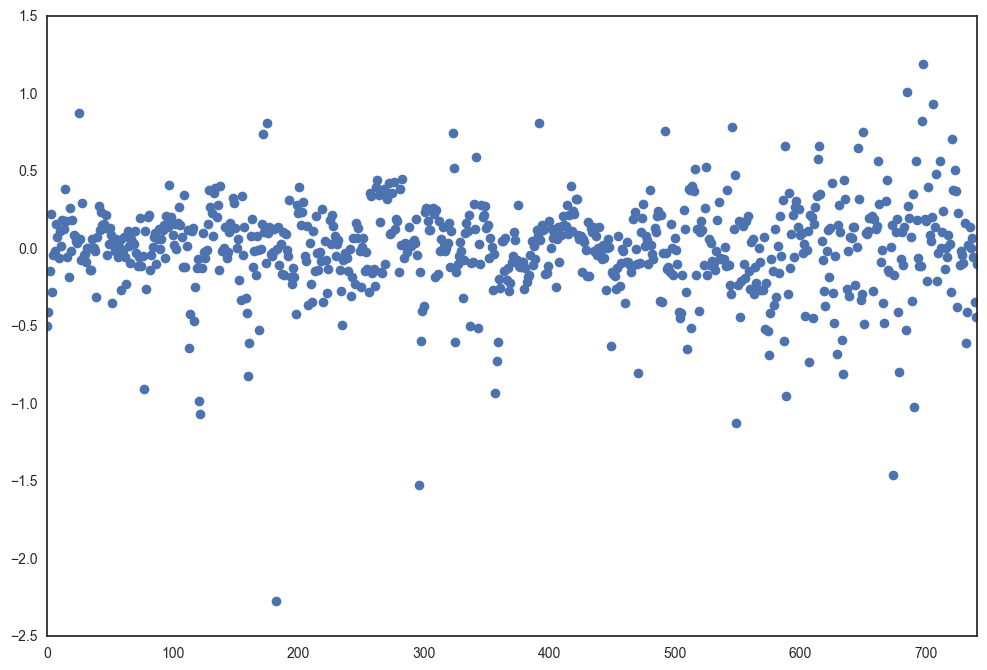

In [26]:
fit.resid.plot(style='o', figsize=(12,8));

### _Model 2: Drop book weeks on list, author gender not reported_

In [28]:
model2 = model1.drop(['b_wks_on_list_bx', 'a_not reported'], axis=1)

In [29]:
lsm = sm.OLS(y,model2)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           b_avg_rating   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     290.5
Date:                Fri, 03 Feb 2017   Prob (F-statistic):               0.00
Time:                        02:15:42   Log-Likelihood:                -158.96
No. Observations:                 742   AIC:                             367.9
Df Residuals:                     717   BIC:                             483.2
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
b_txt_rev_count            -0.1363      0.023     -5.886      0.000        -0.182    -0.091
b_rating_2_count            0.2775      0.043      6.420      0.000         0.193     0.362
b_rating_1_count           -0.1601      0.034     -4.660      0.000        -0.228    -0.093
a_fans_count                0.0259      0.021      1.251      0.211        -0.015     0.067
a_avg_rating                0.0927      0.016      5.684      0.000         0.061     0.125
b_count_bx                 -0.0698      0.019     -3.603      0.000        -0.108    -0.032
b_rating_5_count_bx         1.4331      0.090     15.974      0.000         1.257     1.609
b_rating_4_count_bx         2.4042      0.152     15.869      0.000         2.107     2.702
b_rating_3_count_bx        -3.6200      0.094    -38.707      0.000        -3.804    -3.436
a_works_count_bx            0.0290      0.022      1.324      0.186        -0.014     0.072
a_ratings_count_bx          0.0419      0.070      0.597      0.550        -0.096     0.180
a_text_reviews_count_bx    -0.1112      0.071     -1.571      0.117        -0.250     0.028
a_wks_on_list_bx           -0.0567      0.029     -1.933      0.054        -0.114     0.001
a_books_on_list_bx          0.1156      0.036      3.252      0.001         0.046     0.185
a_ny_hometown               0.0406      0.033      1.235      0.217        -0.024     0.105
a_male                     -0.1261      0.028     -4.480      0.000        -0.181    -0.071
b_1950s                    -0.1998      0.068     -2.956      0.003        -0.333    -0.067
b_1960s                    -0.1622      0.068     -2.379      0.018        -0.296    -0.028
b_1970s                    -0.1936      0.065     -3.000      0.003        -0.320    -0.067
b_1980s                    -0.1324      0.056     -2.374      0.018        -0.242    -0.023
b_1990s                    -0.1526      0.057     -2.675      0.008        -0.265    -0.041
b_2000s                    -0.1394      0.054     -2.596      0.010        -0.245    -0.034
b_2010s                    -0.2529      0.057     -4.430      0.000        -0.365    -0.141
b_repeat                    0.1760      0.033      5.338      0.000         0.111     0.241
a_repeat                    0.1310      0.049      2.668      0.008         0.035     0.227
==============================================================================
Omnibus:                      215.172   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1677.638
Skew:                          -1.080   Prob(JB):                         0.00
Kurtosis:                      10.043   Cond. No.                         42.4
==============================================================================

Warnings:
[1] Standard Errors as

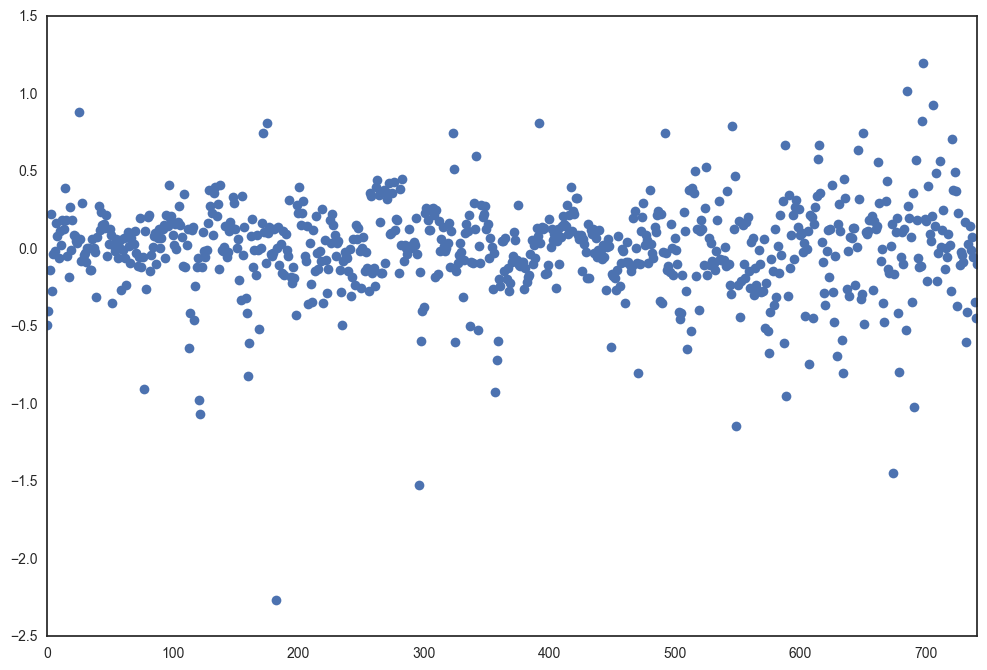

In [30]:
fit.resid.plot(style='o', figsize=(12,8));

### _Model 3: Drop ratings_

In [31]:
model3 = model2.drop(['b_rating_5_count_bx', 'b_rating_4_count_bx', 'b_rating_3_count_bx', 'b_rating_2_count', 'b_rating_1_count'], axis=1)

In [32]:
lsm = sm.OLS(y,model3)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           b_avg_rating   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     30.23
Date:                Fri, 03 Feb 2017   Prob (F-statistic):           1.18e-81
Time:                        02:17:16   Log-Likelihood:                -827.15
No. Observations:                 742   AIC:                             1694.
Df Residuals:                     722   BIC:                             1786.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
b_txt_rev_count             0.1053      0.041      2.539      0.011         0.024     0.187
a_fans_count               -0.0274      0.049     -0.560      0.575        -0.123     0.069
a_avg_rating                0.6613      0.031     21.073      0.000         0.600     0.723
b_count_bx                  0.0156      0.038      0.413      0.680        -0.059     0.090
a_works_count_bx            0.1067      0.050      2.146      0.032         0.009     0.204
a_ratings_count_bx         -0.3821      0.154     -2.474      0.014        -0.685    -0.079
a_text_reviews_count_bx     0.1491      0.165      0.902      0.367        -0.175     0.473
a_wks_on_list_bx           -0.1955      0.071     -2.739      0.006        -0.336    -0.055
a_books_on_list_bx          0.2050      0.085      2.417      0.016         0.038     0.372
a_ny_hometown               0.0936      0.080      1.176      0.240        -0.063     0.250
a_male                      0.0722      0.064      1.136      0.256        -0.053     0.197
b_1950s                    -0.2339      0.166     -1.412      0.158        -0.559     0.091
b_1960s                    -0.0880      0.166     -0.529      0.597        -0.414     0.238
b_1970s                    -0.1794      0.156     -1.147      0.252        -0.486     0.128
b_1980s                    -0.0535      0.131     -0.408      0.684        -0.311     0.204
b_1990s                    -0.0783      0.134     -0.586      0.558        -0.341     0.184
b_2000s                    -0.1625      0.126     -1.289      0.198        -0.410     0.085
b_2010s                    -0.0351      0.136     -0.259      0.796        -0.302     0.232
b_repeat                    0.1461      0.080      1.816      0.070        -0.012     0.304
a_repeat                   -0.0491      0.116     -0.425      0.671        -0.276     0.178
==============================================================================
Omnibus:                      139.226   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              383.858
Skew:                          -0.941   Prob(JB):                     4.43e-84
Kurtosis:                       5.979   Cond. No.                         22.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

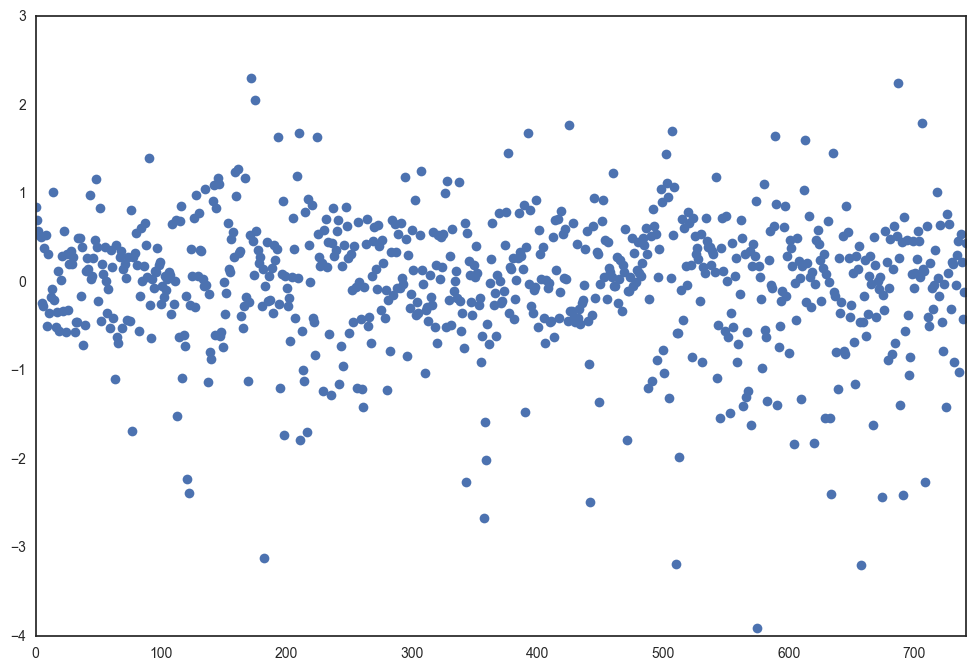

In [33]:
fit.resid.plot(style='o', figsize=(12,8));

### _Model 4: only author rating_

In [34]:
model4 = books['a_avg_rating']

In [35]:
lsm = sm.OLS(y,model4)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           b_avg_rating   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     535.5
Date:                Fri, 03 Feb 2017   Prob (F-statistic):           1.39e-89
Time:                        02:17:24   Log-Likelihood:                -851.08
No. Observations:                 742   AIC:                             1704.
Df Residuals:                     741   BIC:                             1709.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
a_avg_rating     0.6477      0.028     23.140      0.000         0.593     0.703
==============================================================================
Omnibus:                      179.358   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              583.354
Skew:                          -1.144   Prob(JB):                    2.12e-127
Kurtosis:                       6.693   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

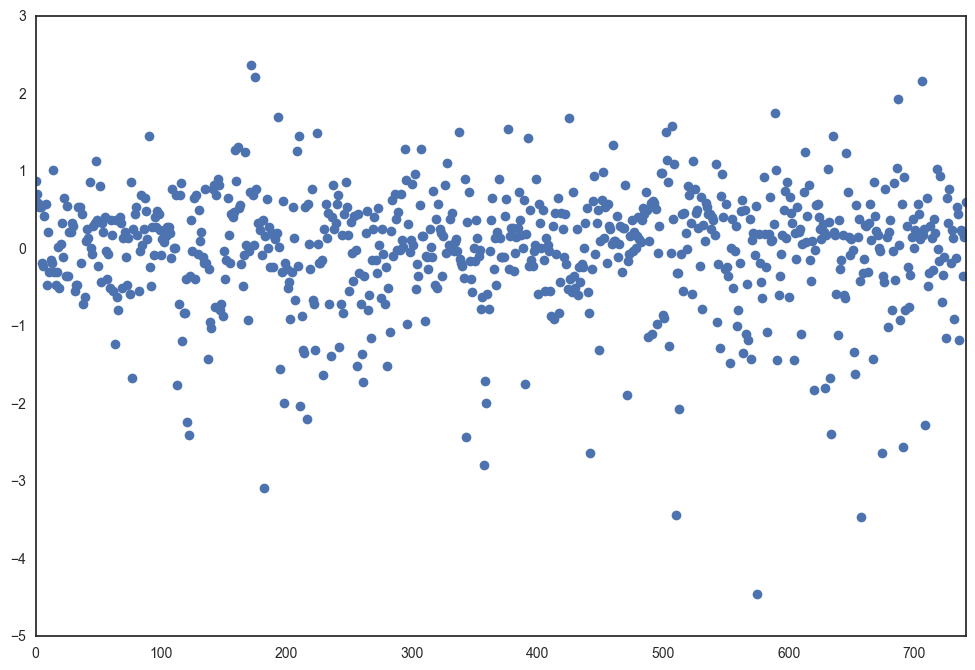

In [36]:
fit.resid.plot(style='o', figsize=(12,8));

### Cross validation of Model 3

In [37]:
# 10-fold cross-validation
reg = LinearRegression()
scores = cross_val_score(reg, model1, y, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print np.sqrt(-scores.mean())

0.387884259987


In [38]:
def calc_avg_RMSE(model, X, y):
    scores = cross_val_score(model, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
    return np.sqrt(-scores.mean())

In [47]:
def find_best_model(X_scaled, y):
    '''
    model_type: LR, Lasso, Ridge, EN
    '''
    
    avg_RMSEs = {}
    
    #linear
    #model_LR = LinearRegression()
    
    
    #lasso
    model_LassoCV = LassoCV(cv=5, normalize=False)
    model_LassoCV.fit(X_scaled, y)
    model_Lasso = Lasso(alpha=model_LassoCV.alpha_)
    avg_RMSEs['lasso'] = calc_avg_RMSE(model_Lasso, X_scaled, y)
    
    #ridge
    model_RidgeCV = RidgeCV(cv=5, normalize=False)
    model_RidgeCV.fit(X_scaled, y)
    model_Ridge = Ridge(alpha=model_RidgeCV.alpha_)
    avg_RMSEs['ridge'] = calc_avg_RMSE(model_Ridge, X_scaled, y)
    
    #elasticnet
    model_ElasticCV = ElasticNetCV(cv=5, normalize=False)
    model_ElasticCV.fit(X_scaled, y)
    model_Elastic = ElasticNet(alpha=model_ElasticCV.alpha_)
    avg_RMSEs['elasticnet'] = calc_avg_RMSE(model_Elastic, X_scaled, y)
    
    models = {'lasso': model_Lasso,
             'ridge': model_Ridge,
             'elasticnet': model_Elastic}
    
    best_model_name =  min(avg_RMSEs.iteritems(), key=operator.itemgetter(1))[0]
    
    print avg_RMSEs
    
    #print 'best model: ', best_model_name
    #print 'avg RMSE: ', avg_RMSEs[best_model_name]
    #print 'coefficients: ', model_Elastic.get_params()

In [48]:
find_best_model(model1, y)

{'elasticnet': 0.34997043699070002, 'ridge': 0.36449102281156665, 'lasso': 0.33497414119729524}
